# Data Science and Machine Learning - Case Study: Multinomial Stock Returns

# Short Overview

Nevasalmi (2020) compares several machine learning methods for forecasting multinomial stock returns of the S&P 500 index. This study uses the empirical strategy on a different index, namely the Wilshire 5000 Total Market Index in the time span from 01.01.1991 until 01.11.2021.
First, we obtain data from Thompson Reuters Datastream and create returns for certain relevant timeseries. We preprocess the data and generate ten lagged variables for each one. We split the data along the time dimension into training and test data sets and search for optimal hyperparameters for each method within the respective training periods. Running the machine learning methods one by one in order to predict daily return classes, we then compare the models‘ performance in a trading simulation. 

Following Nevasalmi (2020) we implement five machine learning methods: Gradient Boosting, K-nearest Neighbor classifier, Random Forest, Neural Networks and Support Vector Machine. 	      We deviate in some ways: We do not correct our multinomial Return Z(t) by the contemporary interest rate level and instead of logarithmic returns we use standard returns. Also, we re-estimate the models on a bi-annual basis using an expanding window approach. We fit the models on a preliminary training sample with data from 1991 through 2007 and select hyperparameters for the models, in order to estimate multinomial returns for 2008 and 2009. Then we expand the training data through 2009, selecting new hyperparameters and estimate returns for the following two years. This approach is repeated several times until we obtain returns for the final timespan of 2020 through November 2021. Based on the predictions for daily multinomial return classes we implement a threefold trading strategy (sell, hold, buy) for each machine learning method and compare it to a simple Buy and Hold strategy. Unlike Nevasalmi we do not consider trading costs.

# Data

All of the data used, we obtained from Thompson Reuters Datastream. 
Now we give you an overview of our data and briefly explain why exactly we used it.
Our goal is to predict multinomial stock returns of the Wilshire 5000 total market price index. This index is intended to measure the performance of all companies headquartered in the USA which are actively traded on the stock market. 
To predict this index, we searched for features that are most likely to have an impact on the companies listed in the Wilshire 5000.
At first, our strategy was to look the other major indices like the S&P 500 composite price index, the DAX performance price index, the Dow Jones Industrials and the FTSE 100 price index. Furthermore, we added interest rates and exchange rates to our data. The performance of the dollar relative to other currencies affects the foreign trade and international flow of funds to the U.S. Variables related to the state of the macroeconomy are found to be important features when predicting monthly stock returns. Macroeconomic variables also include, for example, the unemployment rate and GDP, which is why we also take these variables into account in our analysis. Also, we belive that metals are interesting features to predict the returns of the Wilshire 5000. This is due to the fact that metals like copper or gold are used in any type of production and more. All in all, we use 22 predictors in this research. Later in our analysis, we get rid of some features due to weak correlation with the Wilshire 5000. 

# Main Analysis

First, we import all packages we need for our analysis:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

Now, we import the excel sheet which contains our dependent variable as well as all the predictors we chose for our analysis:

In [3]:
%matplotlib inline
df = pd.read_excel(r'/path/to/DSML_Predictors_final.xlsx', sheet_name = 'Predictors (täglich)',header = 4, usecols="A:AO")
df.head()

,DATE,USTB3Md_t,Zt,Class_p,WILL_t,RABS_WIL_t,R_WIL_t,SQR_WIL_t,DAX_t,R_DAX_t,...,R_INFL_t,USDJ_t,R_USDJ_t,USFFTR_t,R_USFFTR_t,UR_t,R_UR_t,USGDP_t,R_USGDP_t,VIX_t
0,1991-01-01 00:00:00,0.017722,-0.017722,1.0,3101.36,0.000000,0.000000,0.000000,1398.23,0.000000,...,0.0,2736.39,0.0,6.75,0.0,6.4,0.0,9275.276,0.0,26.38
1,1991-01-02 00:00:00,0.017722,-0.022195,1.0,3069.58,-0.010247,-0.004473,0.000020,1366.10,-0.010096,...,0.0,2736.39,0.0,6.75,0.0,6.4,0.0,9275.276,0.0,26.62
2,1991-01-03 00:00:00,0.017722,-0.022967,1.0,3032.73,-0.012005,-0.005245,0.000028,1366.65,0.000175,...,0.0,2736.39,0.0,6.75,0.0,6.4,0.0,9275.276,0.0,27.93
3,1991-01-04 00:00:00,0.017722,-0.018856,1.0,3024.82,-0.002608,-0.001134,0.000001,1396.07,0.009250,...,0.0,2736.39,0.0,6.75,0.0,6.4,0.0,9275.276,0.0,27.19
4,1991-01-07 00:00:00,0.017722,-0.025084,1.0,2973.98,-0.016808,-0.007361,0.000054,1358.16,-0.011956,...,0.0,2736.39,0.0,6.75,0.0,6.4,0.0,9275.276,0.0,28.95


# Preprocessing

In order to run our models, some preprocessing of our data is necessary. Therefore, we delete all of the missing data and create our final dataset with all relevant columns. 

In [4]:
"""Delete first row below header (no information) and reasign new indices"""
#df.drop(labels=0, axis=0, inplace = True)
#df.reset_index(drop = True, inplace = True)
print(df)

                     DATE  USTB3Md_t        Zt  Class_p    WILL_t  RABS_WIL_t  \
0     1991-01-01 00:00:00   0.017722 -0.017722      1.0   3101.36    0.000000   
1     1991-01-02 00:00:00   0.017722 -0.022195      1.0   3069.58   -0.010247   
2     1991-01-03 00:00:00   0.017722 -0.022967      1.0   3032.73   -0.012005   
3     1991-01-04 00:00:00   0.017722 -0.018856      1.0   3024.82   -0.002608   
4     1991-01-07 00:00:00   0.017722 -0.025084      1.0   2973.98   -0.016808   
...                   ...        ...       ...      ...       ...         ...   
8041  2021-10-27 00:00:00   0.000139 -0.003198      2.0  47102.37   -0.007019   
8042  2021-10-28 00:00:00   0.000139  0.004628      2.0  47622.27    0.011038   
8043  2021-10-29 00:00:00   0.000139  0.000483      2.0  47690.50    0.001433   
8044  2021-11-01 00:00:00   0.000167  0.001776      2.0  47904.27    0.004482   
8045                  MAX        NaN       NaN      NaN  47904.27         NaN   

       R_WIL_t     SQR_WIL_

In [5]:
"""Find rows with missing value and delete them"""
delete_rows = []
for i in range(0, len(df)):
    for j in range(1,1):
        if(np.isnan(df.iloc[i][j]) or df.iloc[i][j] == 0):
            delete_rows.append(i)
            break  
#print("Zeilen mit folgenden Indices werden gelöscht:", delete_rows)
df.drop(labels=delete_rows, axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
"""Dataframe mit relevanten Spalten erstellen"""
df_final = df[['DATE', 'Class_p', 'RABS_WIL_t','R_WIL_t','SQR_WIL_t','R_DAX_t','R_FTSE_t','R_USDUK_t','R_COP_t', 'R_USD_t', 'R_S&P_t', 'R_USPYC1Y_t', 'R_USPYC10Y_t', 'R_USPYC30Y_t', 'R_LIB3M_t', 'R_USTB3M_t', 'R_INFL_t', 'R_USDJ_t', 'R_USFFTR_t', 'R_UR_t', 'R_USGDP_t', 'VIX_t']]
df_final['R_WIL_t'] = df_final['R_WIL_t'].astype(float)
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.dropna(inplace=True)
df_final.loc[:,'Class'] = 2.0
print(df_final.describe())

           Class_p   RABS_WIL_t      R_WIL_t     SQR_WIL_t      R_DAX_t  \
count  8044.000000  8044.000000  8044.000000  8.044000e+03  8044.000000   
mean      1.439334     0.000403     0.000148  2.385927e-05     0.000131   
std       0.570678     0.011220     0.004883  8.997339e-05     0.005999   
min       1.000000    -0.122876    -0.056939  0.000000e+00    -0.056697   
25%       1.000000    -0.003936    -0.001713  6.461532e-07    -0.002499   
50%       1.000000     0.000400     0.000174  4.157272e-06     0.000214   
75%       2.000000     0.005287     0.002290  1.802552e-05     0.003091   
max       3.000000     0.113758     0.046791  3.242064e-03     0.046893   

          R_FTSE_t    R_USDUK_t      R_COP_t      R_USD_t      R_S&P_t  ...  \
count  8044.000000  8044.000000  8044.000000  8044.000000  8044.000000  ...   
mean      0.000066    -0.000018     0.000072     0.000007     0.000142  ...   
std       0.004760     0.002543     0.006757     0.002153     0.004891  ...   
min     

In [7]:
df_final.head()

,DATE,Class_p,RABS_WIL_t,R_WIL_t,SQR_WIL_t,R_DAX_t,R_FTSE_t,R_USDUK_t,R_COP_t,R_USD_t,...,R_USPYC30Y_t,R_LIB3M_t,R_USTB3M_t,R_INFL_t,R_USDJ_t,R_USFFTR_t,R_UR_t,R_USGDP_t,VIX_t,Class
0,1991-01-01 00:00:00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,26.38,2.0
1,1991-01-02 00:00:00,1.0,-0.010247,-0.004473,0.000020,-0.010096,-0.003091,0.002804,0.009793,-0.001466,...,-0.1200,-0.01563,0.0,0.0,0.0,0.0,0.0,0.0,26.62,2.0
2,1991-01-03 00:00:00,1.0,-0.012005,-0.005245,0.000028,0.000175,-0.002148,0.000893,-0.002137,0.000105,...,-0.0302,-0.18750,0.0,0.0,0.0,0.0,0.0,0.0,27.93,2.0
3,1991-01-04 00:00:00,1.0,-0.002608,-0.001134,0.000001,0.009250,0.001699,-0.002910,-0.009739,0.002875,...,0.1084,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,27.19,2.0
4,1991-01-07 00:00:00,1.0,-0.016808,-0.007361,0.000054,-0.011956,-0.002623,-0.006221,0.003804,0.006772,...,0.0966,0.20313,0.0,0.0,0.0,0.0,0.0,0.0,28.95,2.0


In [8]:
# Analysis of the dependent variable
#sns.distplot(df_final['Class'], color='grey')
#plt.show()

# Lags erstellen

Now, we create Lags of our predictors: 

In [9]:
#Lags für Return WIL
for i in [1,2,3,4,5,6,7,8,9,10]:
    df_final['R_WIL_t-'+str(i)] = df['R_WIL_t'].shift(i)
    df_final['SQR_WIL_t-'+str(i)] = df['SQR_WIL_t'].shift(i)
    df_final['R_DAX_t-'+str(i)] = df['R_DAX_t'].shift(i)
    df_final['R_FTSE_t-'+str(i)] = df['R_FTSE_t'].shift(i)
    df_final['R_USDUK_t-'+str(i)] = df['R_USDUK_t'].shift(i)
    df_final['R_COP_t-'+str(i)] = df['R_COP_t'].shift(i)
    df_final['R_USD_t-'+str(i)] = df['R_USD_t'].shift(i)
    df_final['R_S&P_t-'+str(i)] = df['R_S&P_t'].shift(i)
    df_final['R_USPYC1Y_t-'+str(i)] = df['R_USPYC1Y_t'].shift(i)
    df_final['R_USPYC10Y_t-'+str(i)] = df['R_USPYC10Y_t'].shift(i)
    df_final['R_USPYC30Y_t-'+str(i)] = df['R_USPYC30Y_t'].shift(i)
    df_final['R_LIB3M_t-'+str(i)] = df['R_LIB3M_t'].shift(i)
    df_final['R_USTB3M_t-'+str(i)] = df['R_USTB3M_t'].shift(i)
    df_final['R_INFL_t-'+str(i)] = df['R_INFL_t'].shift(i)
    df_final['R_USDJ_t-'+str(i)] = df['R_USDJ_t'].shift(i)
    df_final['R_USFFTR_t-'+str(i)] = df['R_USFFTR_t'].shift(i)
    df_final['R_UR_t-'+str(i)] = df['R_UR_t'].shift(i)
    df_final['R_USGDP_t-'+str(i)] = df['R_USGDP_t'].shift(i)
    df_final['VIX_t-'+str(i)] = df['VIX_t'].shift(i)
    

In [10]:
df_final.head()

,DATE,Class_p,RABS_WIL_t,R_WIL_t,SQR_WIL_t,R_DAX_t,R_FTSE_t,R_USDUK_t,R_COP_t,R_USD_t,...,R_USPYC10Y_t-10,R_USPYC30Y_t-10,R_LIB3M_t-10,R_USTB3M_t-10,R_INFL_t-10,R_USDJ_t-10,R_USFFTR_t-10,R_UR_t-10,R_USGDP_t-10,VIX_t-10
0,1991-01-01 00:00:00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-01-02 00:00:00,1.0,-0.010247,-0.004473,0.000020,-0.010096,-0.003091,0.002804,0.009793,-0.001466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-01-03 00:00:00,1.0,-0.012005,-0.005245,0.000028,0.000175,-0.002148,0.000893,-0.002137,0.000105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-01-04 00:00:00,1.0,-0.002608,-0.001134,0.000001,0.009250,0.001699,-0.002910,-0.009739,0.002875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-01-07 00:00:00,1.0,-0.016808,-0.007361,0.000054,-0.011956,-0.002623,-0.006221,0.003804,0.006772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_final.dropna(inplace=True)
df_final.reset_index(drop = True, inplace = True)

# Visualization of the data

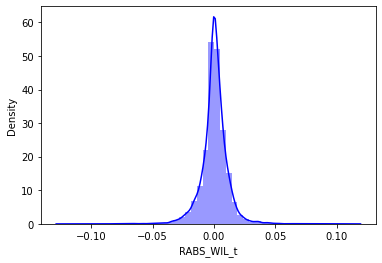

In [12]:
# Analysis of the dependent variable
sns.distplot(df_final['RABS_WIL_t'], color='blue')
plt.show()

We can find a normal distribution of our dependent variable, which is the absolute return of the Wilshire 5000.

,DATE,Class_p,RABS_WIL_t,R_WIL_t,SQR_WIL_t,R_DAX_t,R_FTSE_t,R_USDUK_t,R_COP_t,R_USD_t,...,R_USPYC10Y_t-10,R_USPYC30Y_t-10,R_LIB3M_t-10,R_USTB3M_t-10,R_INFL_t-10,R_USDJ_t-10,R_USFFTR_t-10,R_UR_t-10,R_USGDP_t-10,VIX_t-10
0,1991-01-15 00:00:00,1.0,0.002977,0.001291,1.666716e-06,-0.000714,-0.002071,-0.000114,-0.003209,0.000102,...,0.0000,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,26.38
1,1991-01-16 00:00:00,1.0,0.009207,0.003980,1.584132e-05,-0.000964,-0.003390,-0.000114,-0.017523,0.001329,...,-0.1101,-0.1200,-0.01563,0.0,0.0,0.0,0.0,0.0,0.0,26.62
2,1991-01-17 00:00:00,2.0,0.034313,0.014652,2.146758e-04,0.031649,0.010400,0.004425,0.020750,-0.008971,...,-0.0448,-0.0302,-0.18750,0.0,0.0,0.0,0.0,0.0,0.0,27.93
3,1991-01-18 00:00:00,1.0,0.009905,0.004281,1.832469e-05,-0.005409,-0.000392,0.004157,-0.003494,-0.003137,...,0.0834,0.1084,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,27.19
4,1991-01-21 00:00:00,1.0,-0.002272,-0.000988,9.757231e-07,-0.004618,-0.003880,0.002564,-0.008706,-0.001682,...,0.1268,0.0966,0.20313,0.0,0.0,0.0,0.0,0.0,0.0,28.95


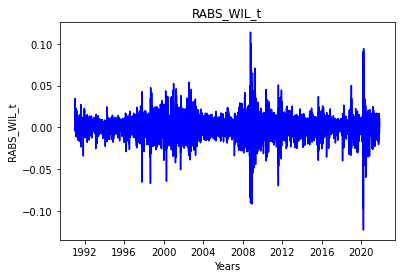

In [13]:
# Wilshire 5000 index
RABS_WIL_t = 'RABS_WIL_t'
DATE = 'DATE'

x = df_final[DATE]
y = df_final[RABS_WIL_t]

plt.title(RABS_WIL_t)
plt.xlabel('Years')
plt.ylabel('RABS_WIL_t')

plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y,'b')
df_final.head()

In this graph above we can see a stationary time series of the Wilshire 5000. It remains relatively constant exepct of two deviations. This is due to the financial crisis in 2008/2009 and because of the Covid Pandemic in 2020. 

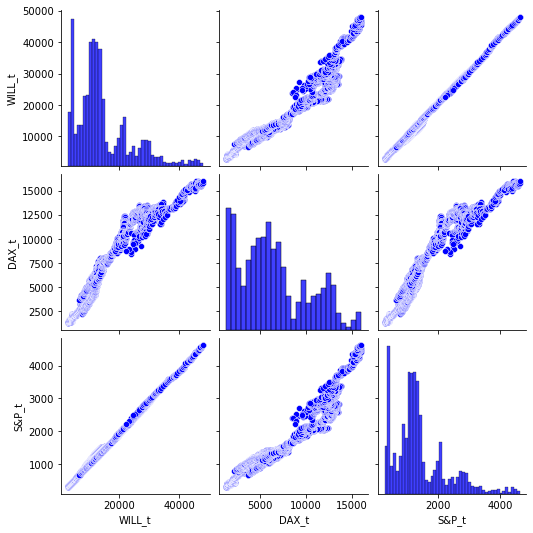

In [14]:
df_final1 = df[['WILL_t', 'DAX_t', 'S&P_t']]
sns.pairplot(df_final1 , plot_kws={'color':'blue'}, diag_kws={'color':'blue'})
plt.show()

Here, we compute the simultaneous correlation of the returns of the Wilshire 5000 with the main indices in the USA and Europe. We can clearly detect a highly positive and almost linear correlation between the returns of the indices. Also, a main part of the S&P 500 market capitalization is included within the Wilshire 5000. 

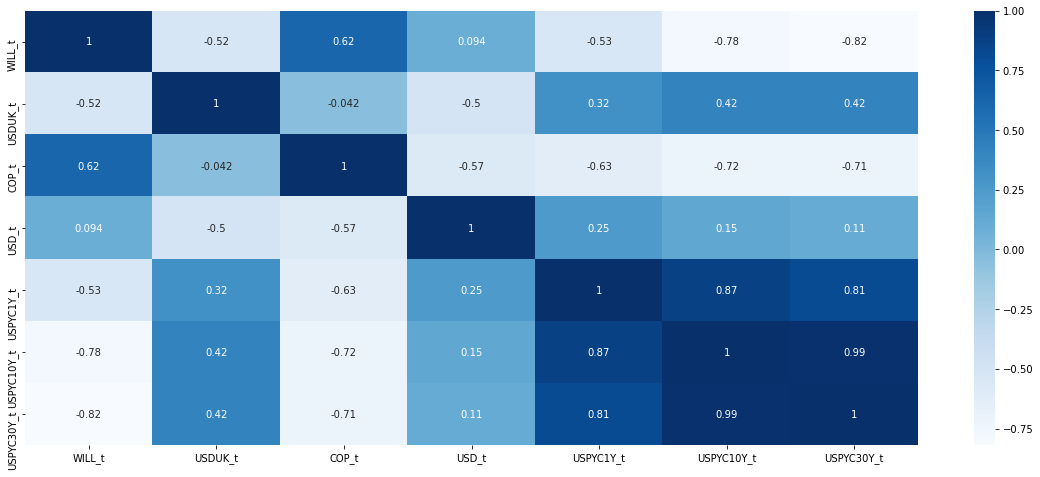

In [15]:
df_final2= df[['WILL_t', 'USDUK_t', 'COP_t', 'USD_t', 'USPYC1Y_t', 'USPYC10Y_t', 'USPYC30Y_t']]
sns.heatmap(df_final2.corr(), annot=True , cmap='Blues') 
plt.show()

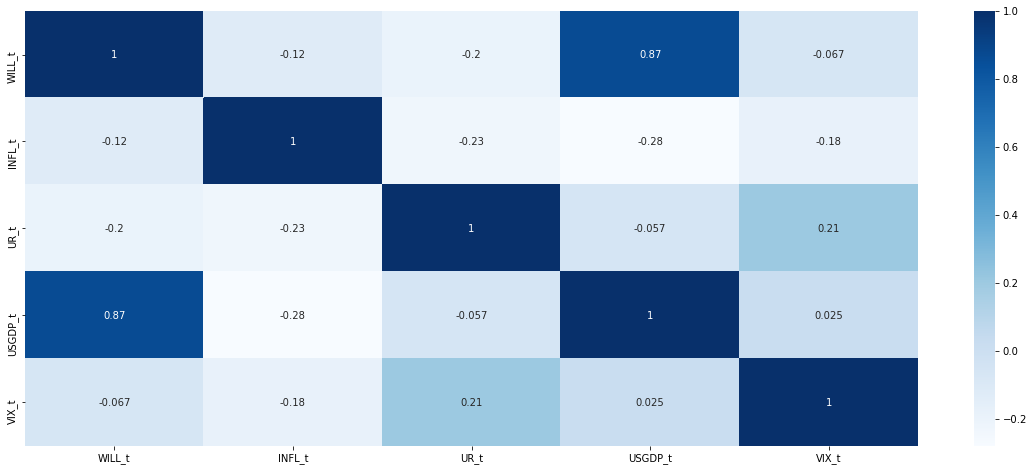

In [16]:
df_final3= df[['WILL_t','INFL_t','UR_t','USGDP_t','VIX_t']]
sns.heatmap(df_final3.corr(), annot=True , cmap='Blues') 
plt.show()

In both heatmaps, we can see the correlation between the Wilshure 5000, which is the underlying index of our dependent variable and our predictors. Those with a low correlation will not be dropped out by our analysis. This is due to the fact that the models (like GBM) do not consider predictors with low correlation which does not have an impact on the model results. We are also considering all of the predictors in every model, because this would be much more time-consuming if we select the variables for each model. Eventually this would lead to better results in our models.

# Dataframes for periods

In order to predict the returns of the Wilshire 5000, we re-estimate the models on a bi-annual basis using an expanding window approach. Therefore, we fit the model with the optimal hyperparameters on the training data from 01.01.1991 to 31.12.2007. After that, we estimate the multinomial returns of the next two years (01.01.2008 to 31.12.2009), which is our test data. We perform this process seven times until we have the final test dataset from 01.01.2020 to 01.11.2021.

In [17]:
def getSubDataframe(dataframe, end_year):
    
    df_sub = pd.DataFrame(columns=list(dataframe))
    df_sub_train = pd.DataFrame(columns=list(dataframe))
    df_sub_test = pd.DataFrame(columns=list(dataframe))
    for i in range(0, len(dataframe)):
        
        year = dataframe.loc[i,'DATE'].year
        
        if year <= end_year:
            
            df_sub = df_sub.append(dataframe.loc[i,:])
            
            if year <= (end_year - 2):
                
                df_sub_train = df_sub_train.append(dataframe.loc[i,:])
                
            if (year > (end_year -2)) and (year <= end_year):
                
                df_sub_test = df_sub_test.append(dataframe.loc[i,:])
        
    return df_sub, df_sub_train, df_sub_test

In [18]:
Perioden = [2009,2011,2013,2015,2017,2019,2021]
print(Perioden)

[2009, 2011, 2013, 2015, 2017, 2019, 2021]


In [19]:
#Erstellen der Dataframes für jede Periode
for i in Perioden:
    globals()[f"df_periode_{i}"],globals()[f"df_train_periode_{i}"],globals()[f"df_test_periode_{i}"] = getSubDataframe(df_final, i)

In [20]:
for i in Perioden:
    globals()[f"df_test_periode_{i}"].reset_index(drop = True, inplace=True)

In [21]:
df_train_periode_2021

,DATE,Class_p,RABS_WIL_t,R_WIL_t,SQR_WIL_t,R_DAX_t,R_FTSE_t,R_USDUK_t,R_COP_t,R_USD_t,...,R_USPYC10Y_t-10,R_USPYC30Y_t-10,R_LIB3M_t-10,R_USTB3M_t-10,R_INFL_t-10,R_USDJ_t-10,R_USFFTR_t-10,R_UR_t-10,R_USGDP_t-10,VIX_t-10
0,1991-01-15,1.0,0.002977,0.001291,1.666716e-06,-0.000714,-0.002071,-0.000114,-0.003209,0.000102,...,0.0000,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,26.38
1,1991-01-16,1.0,0.009207,0.003980,1.584132e-05,-0.000964,-0.003390,-0.000114,-0.017523,0.001329,...,-0.1101,-0.1200,-0.01563,0.0,0.0,0.0,0.0,0.0,0.0,26.62
2,1991-01-17,2.0,0.034313,0.014652,2.146758e-04,0.031649,0.010400,0.004425,0.020750,-0.008971,...,-0.0448,-0.0302,-0.18750,0.0,0.0,0.0,0.0,0.0,0.0,27.93
3,1991-01-18,1.0,0.009905,0.004281,1.832469e-05,-0.005409,-0.000392,0.004157,-0.003494,-0.003137,...,0.0834,0.1084,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,27.19
4,1991-01-21,1.0,-0.002272,-0.000988,9.757231e-07,-0.004618,-0.003880,0.002564,-0.008706,-0.001682,...,0.1268,0.0966,0.20313,0.0,0.0,0.0,0.0,0.0,0.0,28.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7551,2019-12-25,1.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0487,-0.0423,0.00013,0.0,0.0,0.0,0.0,0.0,0.0,14.99
7552,2019-12-26,2.0,0.006657,0.002881,8.302371e-06,0.000000,0.000000,0.001221,0.000000,-0.000534,...,0.1103,0.0911,0.00625,0.0,0.0,0.0,0.0,0.0,0.0,13.94
7553,2019-12-27,1.0,-0.000612,-0.000266,7.059081e-08,0.001178,0.000720,0.003013,-0.000018,-0.002725,...,-0.0780,-0.0646,0.00600,0.0,0.0,0.0,0.0,0.0,0.0,12.63
7554,2019-12-30,1.0,-0.007219,-0.003146,9.899917e-06,-0.002878,-0.003299,0.000779,0.000561,-0.000807,...,0.0649,0.0460,-0.00113,0.0,0.0,0.0,0.0,0.0,0.0,12.14


In [22]:
df_periode_2021

,DATE,Class_p,RABS_WIL_t,R_WIL_t,SQR_WIL_t,R_DAX_t,R_FTSE_t,R_USDUK_t,R_COP_t,R_USD_t,...,R_USPYC10Y_t-10,R_USPYC30Y_t-10,R_LIB3M_t-10,R_USTB3M_t-10,R_INFL_t-10,R_USDJ_t-10,R_USFFTR_t-10,R_UR_t-10,R_USGDP_t-10,VIX_t-10
0,1991-01-15,1.0,0.002977,0.001291,1.666716e-06,-0.000714,-0.002071,-0.000114,-0.003209,0.000102,...,0.0000,0.0000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,26.38
1,1991-01-16,1.0,0.009207,0.003980,1.584132e-05,-0.000964,-0.003390,-0.000114,-0.017523,0.001329,...,-0.1101,-0.1200,-0.01563,0.0,0.0,0.0,0.0,0.0,0.0,26.62
2,1991-01-17,2.0,0.034313,0.014652,2.146758e-04,0.031649,0.010400,0.004425,0.020750,-0.008971,...,-0.0448,-0.0302,-0.18750,0.0,0.0,0.0,0.0,0.0,0.0,27.93
3,1991-01-18,1.0,0.009905,0.004281,1.832469e-05,-0.005409,-0.000392,0.004157,-0.003494,-0.003137,...,0.0834,0.1084,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,27.19
4,1991-01-21,1.0,-0.002272,-0.000988,9.757231e-07,-0.004618,-0.003880,0.002564,-0.008706,-0.001682,...,0.1268,0.0966,0.20313,0.0,0.0,0.0,0.0,0.0,0.0,28.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8029,2021-10-25,2.0,0.005278,0.002286,5.225709e-06,0.001569,0.001100,-0.000095,0.009317,0.000788,...,0.0000,0.0000,0.00062,0.0,0.0,0.0,0.0,0.0,0.0,20.00
8030,2021-10-26,2.0,0.000754,0.000327,1.072123e-07,0.004372,0.003283,0.000678,-0.004999,0.000648,...,-0.0296,-0.0562,0.00500,0.0,0.0,0.0,0.0,0.0,0.0,19.85
8031,2021-10-27,2.0,-0.007019,-0.003059,9.357940e-06,-0.001415,-0.001456,-0.002463,-0.012771,-0.000694,...,-0.0295,-0.0601,-0.00300,0.0,0.0,0.0,0.0,0.0,0.0,18.64
8032,2021-10-28,2.0,0.011038,0.004767,2.272747e-05,-0.000262,-0.000228,0.002715,0.008387,-0.002089,...,-0.0347,-0.0231,-0.00150,0.0,0.0,0.0,0.0,0.0,0.0,16.86


In the following, we define three different threshold pairs. In our further analysis, we only use the 25% and the 75% quantile. Since using the other thresholds would have been too time-consuming, we only continued to calculate with the first two thresholds.

In [23]:
for i in Perioden:
    globals()[f"quantile_25_periode_{i}"] = globals()[f"df_train_periode_{i}"]['RABS_WIL_t'].quantile(.25)
    globals()[f"quantile_75_periode_{i}"] = globals()[f"df_train_periode_{i}"]['RABS_WIL_t'].quantile(.75)
    globals()[f"quantile_33_periode_{i}"] = globals()[f"df_train_periode_{i}"]['RABS_WIL_t'].quantile(.33)
    globals()[f"quantile_67_periode_{i}"] = globals()[f"df_train_periode_{i}"]['RABS_WIL_t'].quantile(.67)
    globals()[f"quantile_20_periode_{i}"] = globals()[f"df_train_periode_{i}"]['RABS_WIL_t'].quantile(.20)
    globals()[f"quantile_80_periode_{i}"] = globals()[f"df_train_periode_{i}"]['RABS_WIL_t'].quantile(.80)
    

In [24]:
quantile_25_periode_2017

-0.004194565435293752

In [25]:
quantile_75_periode_2019

0.005140712571608265

In [26]:
for i in Perioden:
    for j in range(0, len(globals()[f"df_periode_{i}"])):
        if globals()[f"df_periode_{i}"].loc[j,'RABS_WIL_t'] <= globals()[f"quantile_25_periode_{i}"]:
            globals()[f"df_periode_{i}"].loc[j, 'Class'] = 1.0
        elif globals()[f"df_periode_{i}"].loc[j,'RABS_WIL_t'] > globals()[f"quantile_75_periode_{i}"]:
            globals()[f"df_periode_{i}"].loc[j,'Class'] = 3.0
        else:
            globals()[f"df_periode_{i}"].loc[j,'Class'] = 2.0
            
for i in Perioden:
    for j in range(0, len(globals()[f"df_train_periode_{i}"])):
        if globals()[f"df_train_periode_{i}"].loc[j,'RABS_WIL_t'] <= globals()[f"quantile_25_periode_{i}"]:
            globals()[f"df_train_periode_{i}"].loc[j, 'Class'] = 1.0
        elif globals()[f"df_train_periode_{i}"].loc[j,'RABS_WIL_t'] > globals()[f"quantile_75_periode_{i}"]:
            globals()[f"df_train_periode_{i}"].loc[j,'Class'] = 3.0
        else:
            globals()[f"df_train_periode_{i}"].loc[j,'Class'] = 2.0

for i in Perioden:
    for j in range(0, len(globals()[f"df_test_periode_{i}"])):
        if (globals()[f"df_test_periode_{i}"].loc[j,'RABS_WIL_t'] <= globals()[f"quantile_25_periode_{i}"]):
            globals()[f"df_test_periode_{i}"].loc[j, 'Class'] = 1.0
        elif globals()[f"df_test_periode_{i}"].loc[j,'RABS_WIL_t'] > globals()[f"quantile_75_periode_{i}"]:
            globals()[f"df_test_periode_{i}"].loc[j,'Class'] = 3.0
        else:
            globals()[f"df_test_periode_{i}"].loc[j,'Class'] = 2.0
    

In [27]:
df_periode_2019[10:20]

,DATE,Class_p,RABS_WIL_t,R_WIL_t,SQR_WIL_t,R_DAX_t,R_FTSE_t,R_USDUK_t,R_COP_t,R_USD_t,...,R_USPYC10Y_t-10,R_USPYC30Y_t-10,R_LIB3M_t-10,R_USTB3M_t-10,R_INFL_t-10,R_USDJ_t-10,R_USFFTR_t-10,R_UR_t-10,R_USGDP_t-10,VIX_t-10
10,1991-01-29,1.0,0.000698,0.000303,9.189146e-08,-0.000761,-0.000862,0.000993,0.003180,0.001736,...,-0.0163,-0.0271,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,36.16
11,1991-01-30,1.0,0.015215,0.006558,4.300660e-05,0.006394,0.007899,-0.001878,0.004185,-0.001262,...,0.0279,-0.0186,0.06250,0.0,0.0,0.0,0.0,0.0,0.0,33.20
12,1991-01-31,1.0,0.009283,0.004013,1.610439e-05,0.005958,0.003556,0.000885,0.014135,-0.002535,...,-0.2208,-0.1711,-0.18750,0.0,0.0,0.0,0.0,0.0,0.0,27.45
13,1991-02-01,1.0,0.000897,0.000389,1.515103e-07,0.001962,-0.000921,0.002534,-0.008864,-0.001911,...,0.0034,-0.0213,-0.03125,0.0,0.0,0.0,0.0,0.0,0.0,25.39
14,1991-02-04,1.0,0.015448,0.006658,4.432636e-05,0.002586,0.001341,0.000220,-0.004812,-0.001385,...,0.0000,0.0000,-0.15625,0.0,0.0,0.0,0.0,0.0,0.0,24.33
15,1991-02-05,1.0,0.009262,0.004004,1.603123e-05,0.001155,0.005878,0.001316,-0.001101,-0.001872,...,0.0314,0.0657,-0.12500,0.0,0.0,0.0,0.0,0.0,0.0,24.90
16,1991-02-06,1.0,0.018618,0.008011,6.418344e-05,-0.003078,-0.001422,0.003598,0.005642,-0.002742,...,-0.0228,-0.0255,0.06250,0.0,0.0,0.0,0.0,0.0,0.0,23.92
17,1991-02-07,1.0,-0.003383,-0.001471,2.165303e-06,0.002295,0.009570,-0.000652,-0.002219,0.001991,...,-0.0316,-0.0322,-0.18750,0.0,0.0,0.0,0.0,0.0,0.0,22.86
18,1991-02-08,1.0,0.006492,0.002810,7.898145e-06,0.009440,0.000290,-0.002071,0.005688,-0.000269,...,0.0549,0.0635,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,22.20
19,1991-02-11,1.0,0.022917,0.009840,9.683143e-05,0.006146,0.006489,0.002180,0.006944,-0.001884,...,-0.0097,-0.0365,0.06250,0.0,0.0,0.0,0.0,0.0,0.0,23.05


In [28]:
# Analysis of the dependent variable
#sns.distplot(df_final['Class'], color='grey')
#plt.show()

## Preprocessing

In [29]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

for i in Perioden:
    # Train and test data
    globals()[f"x_periode_{i}"] = globals()[f"df_periode_{i}"].drop(['DATE', 'Class', 'Class_p', 'RABS_WIL_t','R_WIL_t','SQR_WIL_t','R_DAX_t','R_FTSE_t','R_USDUK_t','R_COP_t', 'R_USD_t', 'R_S&P_t', 'R_USPYC1Y_t', 'R_USPYC10Y_t', 'R_USPYC30Y_t', 'R_LIB3M_t', 'R_USTB3M_t', 'R_INFL_t', 'R_USDJ_t', 'R_USFFTR_t', 'R_UR_t', 'R_USGDP_t', 'VIX_t'], axis=1)
    globals()[f"y_periode_{i}"] = globals()[f"df_periode_{i}"]['Class']
    globals()[f"x_train_periode_{i}"] = globals()[f"df_train_periode_{i}"].drop(['DATE', 'Class', 'Class_p', 'RABS_WIL_t','R_WIL_t','SQR_WIL_t','R_DAX_t','R_FTSE_t','R_USDUK_t','R_COP_t', 'R_USD_t', 'R_S&P_t', 'R_USPYC1Y_t', 'R_USPYC10Y_t', 'R_USPYC30Y_t', 'R_LIB3M_t', 'R_USTB3M_t', 'R_INFL_t', 'R_USDJ_t', 'R_USFFTR_t', 'R_UR_t', 'R_USGDP_t', 'VIX_t'], axis=1)
    globals()[f"x_test_periode_{i}"] = globals()[f"df_test_periode_{i}"].drop(['DATE', 'Class', 'Class_p', 'RABS_WIL_t','R_WIL_t','SQR_WIL_t','R_DAX_t','R_FTSE_t','R_USDUK_t','R_COP_t', 'R_USD_t', 'R_S&P_t', 'R_USPYC1Y_t', 'R_USPYC10Y_t', 'R_USPYC30Y_t', 'R_LIB3M_t', 'R_USTB3M_t', 'R_INFL_t', 'R_USDJ_t', 'R_USFFTR_t', 'R_UR_t', 'R_USGDP_t', 'VIX_t'], axis=1)
    globals()[f"y_train_periode_{i}"] = globals()[f"df_train_periode_{i}"]['Class']
    globals()[f"y_test_periode_{i}"] = globals()[f"df_test_periode_{i}"]['Class']

    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(globals()[f"y_periode_{i}"])
    globals()[f"encoded_y_periode_{i}"] = encoder.transform(globals()[f"y_periode_{i}"])
    # convert integers to dummy variables (i.e. one hot encoded)
    globals()[f"dummy_y_periode_{i}"] = np_utils.to_categorical(globals()[f"encoded_y_periode_{i}"])
    
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(globals()[f"y_train_periode_{i}"])
    globals()[f"encoded_y_train_periode_{i}"] = encoder.transform(globals()[f"y_train_periode_{i}"])
    # convert integers to dummy variables (i.e. one hot encoded)
    globals()[f"dummy_y_train_periode_{i}"] = np_utils.to_categorical(globals()[f"encoded_y_train_periode_{i}"])

    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(globals()[f"y_test_periode_{i}"])
    globals()[f"encoded_y_test_periode_{i}"] = encoder.transform(globals()[f"y_test_periode_{i}"])
    # convert integers to dummy variables (i.e. one hot encoded)
    globals()[f"dummy_y_test_periode_{i}"] = np_utils.to_categorical(globals()[f"encoded_y_test_periode_{i}"])




In [30]:
df_test_periode_2009['Class']

0      2.0
1      1.0
2      2.0
3      1.0
4      2.0
      ... 
518    2.0
519    2.0
520    2.0
521    2.0
522    1.0
Name: Class, Length: 523, dtype: float64

In [31]:
### scale the variables:
from sklearn.preprocessing import StandardScaler
SC= StandardScaler().fit(globals()[f"x_train_periode_{i}"][list(globals()[f"x_train_periode_{i}"])])
globals()[f"x_train_periode_{i}"][list(globals()[f"x_train_periode_{i}"])]=SC.transform(globals()[f"x_train_periode_{i}"][list(globals()[f"x_train_periode_{i}"])])
globals()[f"x_test_periode_{i}"][list(globals()[f"x_train_periode_{i}"])]=SC.transform(globals()[f"x_test_periode_{i}"][list(globals()[f"x_train_periode_{i}"])])


In [32]:
x_test_periode_2021

,R_WIL_t-1,SQR_WIL_t-1,R_DAX_t-1,R_FTSE_t-1,R_USDUK_t-1,R_COP_t-1,R_USD_t-1,R_S&P_t-1,R_USPYC1Y_t-1,R_USPYC10Y_t-1,...,R_USPYC10Y_t-10,R_USPYC30Y_t-10,R_LIB3M_t-10,R_USTB3M_t-10,R_INFL_t-10,R_USDJ_t-10,R_USFFTR_t-10,R_UR_t-10,R_USGDP_t-10,VIX_t-10
0,0.243546,-0.275285,-0.021926,-0.567026,1.748302,-0.496319,-0.725952,0.243329,-0.147455,0.498838,...,0.729660,0.759941,0.210446,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.828266
1,-0.029506,-0.297442,-0.021926,-0.015853,0.008481,-0.007599,-0.003633,-0.028415,0.016246,0.015246,...,-0.040629,0.306211,0.690175,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.838576
2,0.686580,-0.145053,0.731689,0.747581,-0.768357,0.143574,0.945160,0.742366,-0.231645,-0.871041,...,0.086855,-0.212049,0.260944,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.837287
3,-0.608312,-0.197881,-0.940981,0.206351,-1.510026,-0.630209,-0.024211,-0.682897,-0.608157,-1.444520,...,0.074286,-0.074922,0.425230,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.824400
4,0.281349,-0.268725,-0.534682,-0.594685,1.169755,0.102713,-0.353785,0.297413,0.191640,0.193222,...,-0.313552,-0.028541,0.492224,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.816668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,-0.211688,-0.287579,0.310923,0.169196,-0.586908,-1.433916,-0.280111,-0.127550,0.371711,-0.527672,...,0.015033,0.015824,0.046160,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,0.127931
474,0.458730,-0.226601,0.242866,0.220864,-0.028799,1.369345,0.357838,0.409169,-0.175519,-0.214865,...,-0.516448,-1.117493,0.193613,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,0.108601
475,0.040427,-0.295989,0.715976,0.690595,0.275480,-0.746349,0.293557,0.139538,0.034954,-0.284977,...,-0.514653,-1.196139,-0.075708,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.047329
476,-0.682857,-0.170584,-0.260721,-0.329099,-0.962158,-1.895044,-0.322069,-0.496249,0.165915,-1.491261,...,-0.608021,-0.450005,-0.025210,0.014791,0.005376,-0.035514,0.007487,0.013325,-0.093065,-0.276713


# Models 

Now, we run our five machine learning models and build functions in order to implement the models in the trading strategy.  

## 1. Random Forest

The random forest algorithm uses the results of many decision trees in order to make the best decision or forecasting. Since the individual decision trees can be built and trained quickly and in parallel, the overall algorithm also trains very quickly. Random Forest shows its strength when large amounts of data with many classes, features and training data have to be processed. The variance of the single decisions of many different trees improves the overall result and prediction accuracy. Unlike other machine learning models, the decisions of a Random Forest remain comprehensible and easy to investigate. Why a particular decision was made is not lost in a kind of black box. The requirements that the Random Forest algorithm places on the hardware and its computing power are lower than those of neural networks, for example. The algorithm itself is simple, easy to understand and flexible to use.
https://www.bigdata-insider.de/was-ist-random-forest-a-913937/

In [55]:
"""RF"""
from sklearn.ensemble import RandomForestClassifier
def getRF(n_estimators, min_samples_leaf, max_features, X_train_input, y_train_input, X_test_input):
    classifier = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features)
    classifier.fit(X_train_input, y_train_input)
    y_pred_test = classifier.predict(X_test_input)
    y_pred_train = classifier.predict(X_train_input)
    return y_pred_test, y_pred_train

## 2. K-Nearest Neighbor

The KNN algorithm is one of the most basic algorithms in machine learning. The goal of the KNN algorithm is to find out to which class the point belongs based on the neighbors of the data point to be classified. KNN assumes that similar data points are near to each other. That means, the classification of one data point is dependent of the classification of the k closest data points. Mostly, the Eucledian distance is used to find those k nearest neighbors. The advantage of this algorithm is, that it is easy to implement. On the other hand, the algorithm gets slower the more predictors we use. This is why we decided to use less predictors than in the other machine learning methods to reduce the duration of the algorithm. 
https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

In [36]:
"""KNN"""
from sklearn.neighbors import KNeighborsClassifier
def getKNN(metric_input, weights_input, leaf_size_input, n_neighbors_input, X_train_input, y_train_input, X_test_input):
    knn = KNeighborsClassifier(metric=metric_input, weights=weights_input, leaf_size=leaf_size_input, n_neighbors=n_neighbors_input)
    knn.fit(X_train_input, y_train_input)
    y_pred_test = knn.predict(X_test_input)
    y_pred_train = knn.predict(X_train_input)
    return y_pred_test, y_pred_train

Different starting points can lead to different accuracies. 

## 3. Gradient Boosting

In Gradient Boosting, each tree is fitted on the modified version of the decision tree before. The goal is, to minimize a predetermined loss function by combining the next model with previous models in order to minimize the overall prediction error. The Gradient Boosting algorithm is able to process many different predicors. An anvantage of this method is that for this method, no feature selection is necessary. Irrelevant predictor variables are determined automatically and have no influence on the prognosis. Furthermore, the algorithm is less affected by outliers than other algorithms. A disadvantage of the algorithm is for example the possibility of overfitting of the training data which leads to a less reliable forecast. Also, the algorithm often requires a large computational effort, which may increase the execution time. https://help.sap.com/viewer/feae3cea3cc549aaa9d9de7d363a83e6/2111/de-DE/a2a3eada1d954aeaaaa8259ac2720767.html

In [61]:
"""GBM"""
from sklearn.ensemble import GradientBoostingClassifier
def getGBM(n_estimators_input, max_depth_input, min_samples_split_input, learning_rate_input, n_iter_no_change, x_train, y_train, x_test):     
    classifier = GradientBoostingClassifier(n_estimators = n_estimators_input, max_depth = max_depth_input, min_samples_split=min_samples_split_input, learning_rate=learning_rate_input, n_iter_no_change=n_iter_no_change)
    classifier.fit(x_train, y_train)
    y_pred_test = classifier.predict(x_test)
    y_pred_train = classifier.predict(x_train)
    return y_pred_test, y_pred_train

## 4. Support Vector Machine

The idea of the Support Vector Machine algorithm is to seperate the data into classes with a line or a hyperplane. The import of this algorithm is the data and the output is given through a hyperplane or a line if it is possible to classify the data. The model is able to cope with relatively little training data and still achieve a high level of accuracy in classification. Also, Support Vector Machines are relatively memory efficient and are not bound to linear conditions. On the other hand, it is difficult to explain why exactly a decision of the model was made. Furthermore, the algorithm shows no optimal performance with a large amount of data.
https://mindsquare.de/fachartikel/machine-learning-mit-support-vector-machines/

In [66]:
"""SVC"""
from sklearn.svm import SVC
import collections
def getSVC(kernel_input, C_input, x_train, y_train, x_test):
    classifier = SVC(kernel=kernel_input, C=C_input)
    classifier.fit(x_train, y_train)
    y_pred_test = classifier.predict(x_test)
    y_pred_train = classifier.predict(x_train)
    return y_pred_test, y_pred_train

## 5. Neural Network

Neural networks are based on the structure of the human brain, which processes information via a network of neurons. Artificial neural networks can be described as models consisting of at least two layers - an input layer and an output layer - and usually additional layers in between (hidden layers). The more complex the problem to be solved by the artificial neural network, the more layers are needed. Each layer of the network contains a large number of specialized artificial neurons.Each neuron is assigned a weight, so that neurons are given different importance. The weight, together with a transfer function, decides on the input, which is now forwarded. An activation function and a threshold value calculate and weight the output value of the neuron in the next step. Depending on the information evaluation and weighting, further neurons are linked and activated to a greater or lesser extent. For large amounts of data and many data dimensions, meaningful results can be determined. If the problem is complex, neural networks can provide better results than statistical approaches. On the other hand, neural networks are black boxes. That means we cannot tell why the specific decisions are made. In order to get good results, we need many training data which is why neural networks should be run on graphics cards. https://www.ionos.de/digitalguide/online-marketing/suchmaschinenmarketing/was-ist-ein-neural-network/


In [78]:
from keras.wrappers.scikit_learn import KerasClassifier

In [336]:
# define baseline model
def neural_model(neuron_hidden=20, activation_hidden='tanh', optimizer='adam', dropout=0.1, weight_decay=0.1):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2021 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=1)
model_2021.fit(x_train_periode_2021, y_train_periode_2021)
y_pred_train=model_2021.predict(x_train_periode_2021)
y_pred_test=model_2021.predict(x_test_periode_2021) 

# Trading Strategy

Now, we apply the models on the trading strategy. In the beginning, we start with an initial wealth of 100$. 
Now, we use the classification of the daily returns, in order to implement the trading strategy in accordance with Nevasalmi(2020):  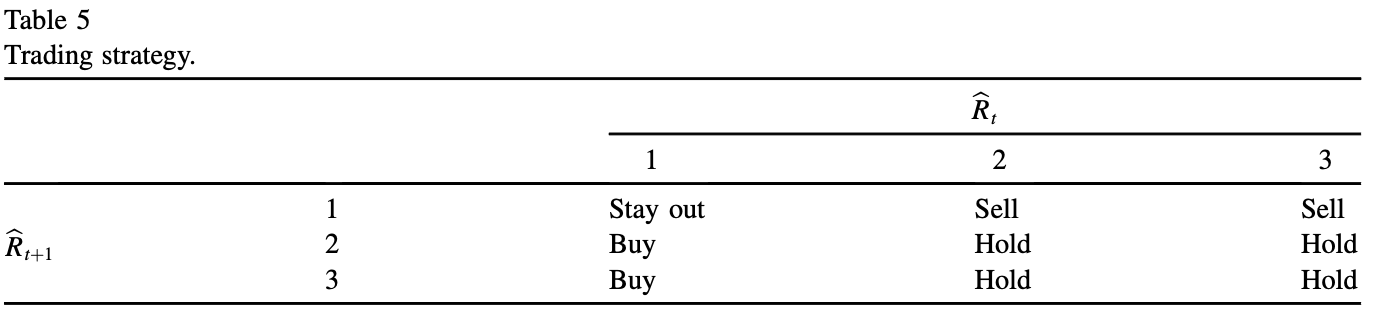 The hyperparameters are implemented manually from Notebook 1, where we calculate the hyperparameters for each model in each period. In the following, we apply the trading strategy for each period seperately. In the end, we show the strategy for the whole perdiod of time.


We define a function for the trading strategy, that includes a variable for the five models:

In [133]:
def getTradingResult(y_pred, year, ml_string): #ml_string = knn, rf, gbm, svc, nn
    returns = globals()[f"df_test_periode_{year}"][['RABS_WIL_t']].values
    if year == 2009:
        total = 100
        bool_holding_shares = True
    else:
        total = globals()[f"trading_{ml_string}_{year-2}"][-1]
        bool_holding_shares = globals()[f"trading_{ml_string}_{year-2}_bool"]
    totals = []
    for i in range(0, len(y_pred) - 1):
        if (y_pred[i] == y_pred[i+1]) or (y_pred[i] == 2 and y_pred[i+1] == 3) or (y_pred[i] == 3 and y_pred[i+1] == 2): #stay out OR hold
            pass
        elif (y_pred[i] == 2 and y_pred[i+1] == 1) or (y_pred[i] == 3 and y_pred[i+1] == 1): #sell
            bool_holding_shares = False
        else: #buy (y_pred[i] == 2 and y_pred[i+1] == 1) or (y_pred[i] == 3 and y_pred[i+1] == 1)
            bool_holding_shares = True
        if bool_holding_shares:
            total = total * (1 + returns[i])
        totals.append(total)
    return totals, bool_holding_shares


total_trading_knn =[]
total_trading_rf = []
total_trading_gbm =[]
total_trading_svc = []
total_trading_nn = []
total_trading_buynhold = [] 

ml_algos = ['knn', 'rf', 'gbm', 'svc', 'nn', 'buynhold'] 

## Fitting the Models and Trading for Periode 2009

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 10)                1910      
                                                                 
 dropout_30 (Dropout)        (None, 10)                0         
                                                                 
 dense_61 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,943
Trainable params: 1,943
Non-trainable params: 0
_________________________________________________________________


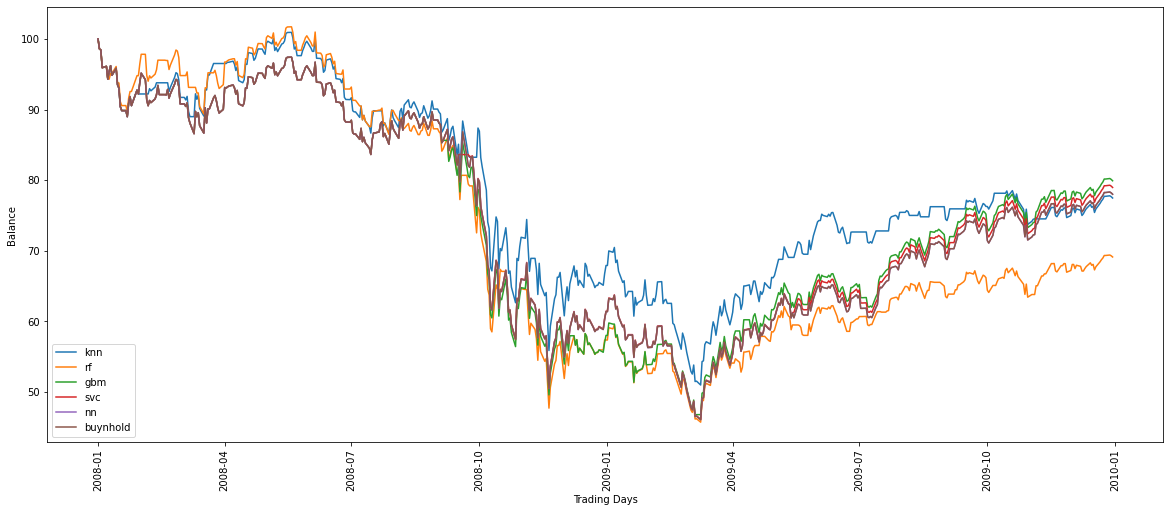

In [134]:
# define baseline model
def neural_model(neuron_hidden=10, activation_hidden='tanh', optimizer='adam', dropout=0.1, weight_decay=0.3):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2009 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2009.fit(x_train_periode_2009, y_train_periode_2009)
y_pred_train_nn=model_2009.predict(x_train_periode_2009)
y_pred_test_nn=model_2009.predict(x_test_periode_2009)


y_pred_test_knn, y_pred_train_knn = getKNN('euclidean', 'uniform', 20, 250, x_train_periode_2009, y_train_periode_2009, x_test_periode_2009)
y_pred_test_rf, y_pred_train_rf = getRF(500, 2, 'log2', x_train_periode_2009, y_train_periode_2009, x_test_periode_2009)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 2, 0.005, 800, x_train_periode_2009, y_train_periode_2009, x_test_periode_2009)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.1, x_train_periode_2009, y_train_periode_2009, x_test_periode_2009)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)

periode = 2009
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc='lower left')

## Fitting the Models and Trading for Periode 2011

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 5)                 955       
                                                                 
 dropout_31 (Dropout)        (None, 5)                 0         
                                                                 
 dense_63 (Dense)            (None, 3)                 18        
                                                                 
Total params: 973
Trainable params: 973
Non-trainable params: 0
_________________________________________________________________


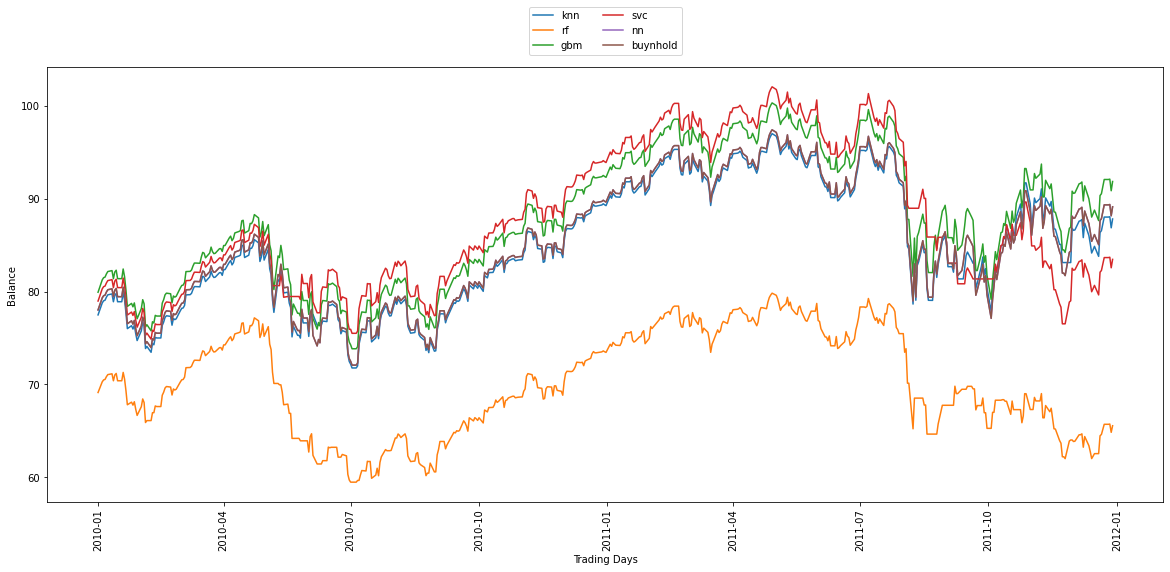

In [135]:
# define baseline model
def neural_model(neuron_hidden=5, activation_hidden='tanh', optimizer='adam', dropout=0.3, weight_decay=0.1):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2011 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2011.fit(x_train_periode_2011, y_train_periode_2011)
y_pred_train_nn=model_2011.predict(x_train_periode_2011)
y_pred_test_nn=model_2011.predict(x_test_periode_2011)


y_pred_test_knn, y_pred_train_knn = getKNN('euclidean', 'uniform', 20, 400, x_train_periode_2011, y_train_periode_2011, x_test_periode_2011)
y_pred_test_rf, y_pred_train_rf = getRF(300, 2, 'log2', x_train_periode_2011, y_train_periode_2011, x_test_periode_2011)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 4, 0.005, 931, x_train_periode_2011, y_train_periode_2011, x_test_periode_2011)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.3, x_train_periode_2011, y_train_periode_2011, x_test_periode_2011)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)

periode = 2011
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

## Fitting the Models and Trading for Periode 2013

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 10)                1910      
                                                                 
 dropout_32 (Dropout)        (None, 10)                0         
                                                                 
 dense_65 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,943
Trainable params: 1,943
Non-trainable params: 0
_________________________________________________________________


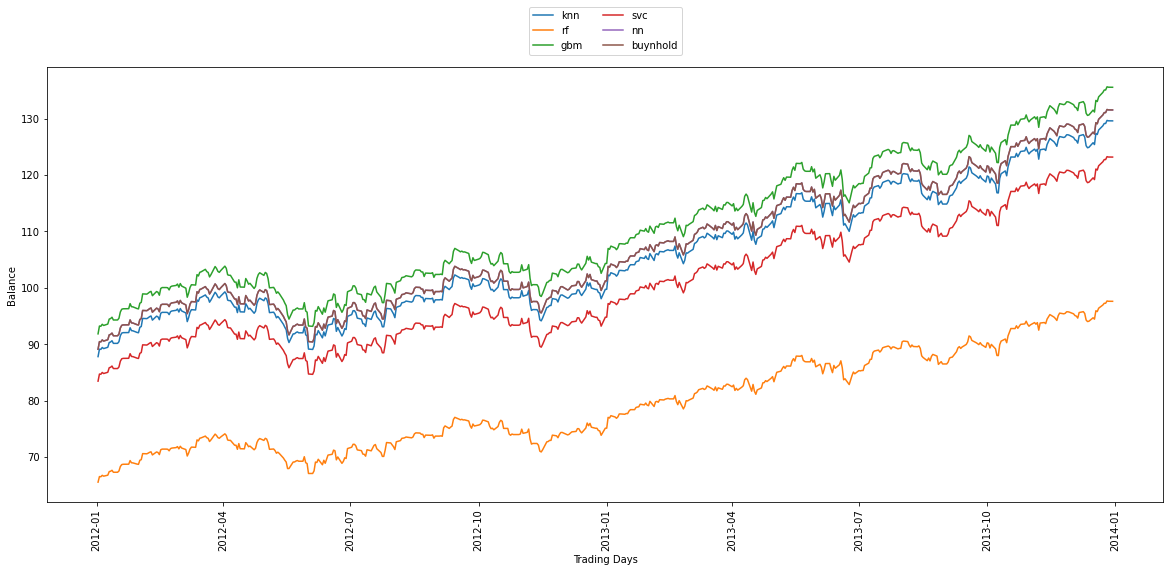

In [136]:
# define baseline model
def neural_model(neuron_hidden=10, activation_hidden='tanh', optimizer='adam', dropout=0.3, weight_decay=0.1):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2013 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2013.fit(x_train_periode_2013, y_train_periode_2013)
y_pred_train_nn=model_2013.predict(x_train_periode_2013)
y_pred_test_nn=model_2013.predict(x_test_periode_2013)


y_pred_test_knn, y_pred_train_knn = getKNN('manhattan', 'uniform', 20, 400, x_train_periode_2013, y_train_periode_2013, x_test_periode_2013)
y_pred_test_rf, y_pred_train_rf = getRF(100, 1, 'log2', x_train_periode_2013, y_train_periode_2013, x_test_periode_2013)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 2, 0.005, 931, x_train_periode_2013, y_train_periode_2013, x_test_periode_2013)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.1, x_train_periode_2013, y_train_periode_2013, x_test_periode_2013)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)


periode = 2013
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

## Fitting the Models and Trading for Periode 2015

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 20)                3820      
                                                                 
 dropout_33 (Dropout)        (None, 20)                0         
                                                                 
 dense_67 (Dense)            (None, 3)                 63        
                                                                 
Total params: 3,883
Trainable params: 3,883
Non-trainable params: 0
_________________________________________________________________


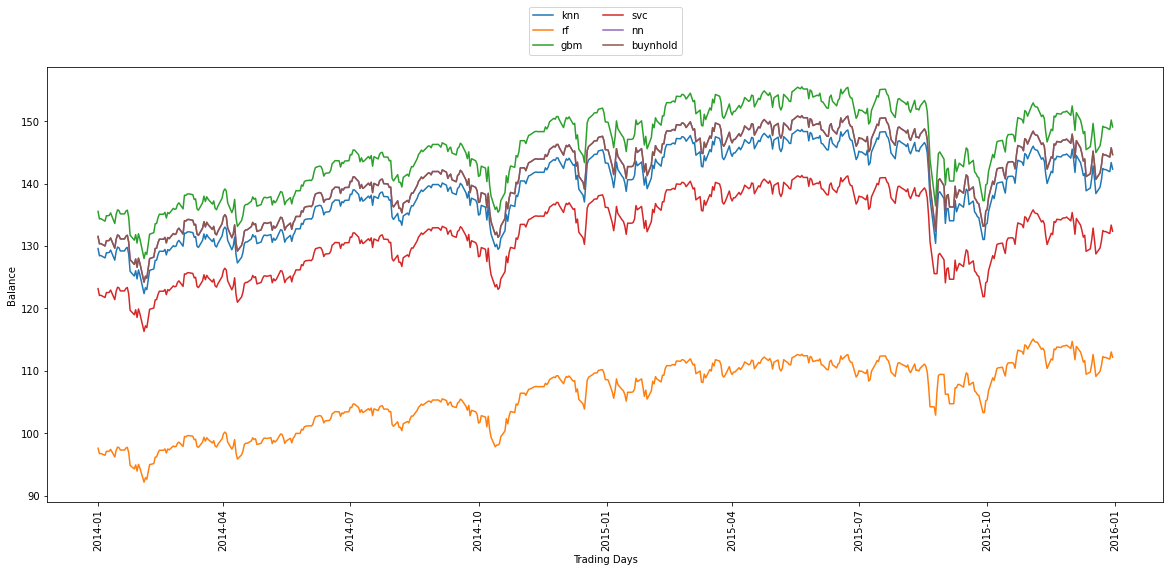

In [137]:
# define baseline model
def neural_model(neuron_hidden=20, activation_hidden='tanh', optimizer='adam', dropout=0.1, weight_decay=0.1):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2015 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2015.fit(x_train_periode_2015, y_train_periode_2015)
y_pred_train_nn=model_2015.predict(x_train_periode_2015)
y_pred_test_nn=model_2015.predict(x_test_periode_2015)


y_pred_test_knn, y_pred_train_knn = getKNN('manhattan', 'uniform', 20, 400, x_train_periode_2015, y_train_periode_2015, x_test_periode_2015)
y_pred_test_rf, y_pred_train_rf = getRF(100, 2, 'log2', x_train_periode_2015, y_train_periode_2015, x_test_periode_2015)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 2, 0.005, 931, x_train_periode_2015, y_train_periode_2015, x_test_periode_2015)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.1, x_train_periode_2015, y_train_periode_2015, x_test_periode_2015)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)

periode = 2015
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

## Fitting the Models and Trading for Periode 2017

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 20)                3820      
                                                                 
 dropout_34 (Dropout)        (None, 20)                0         
                                                                 
 dense_69 (Dense)            (None, 3)                 63        
                                                                 
Total params: 3,883
Trainable params: 3,883
Non-trainable params: 0
_________________________________________________________________


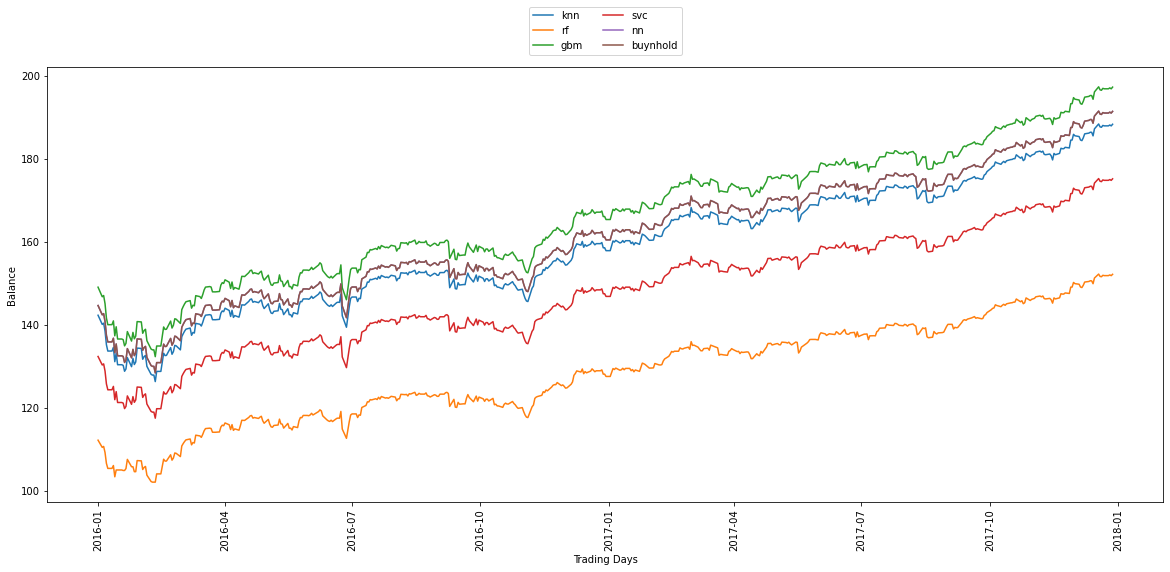

In [138]:
# define baseline model
def neural_model(neuron_hidden=20, activation_hidden='tanh', optimizer='adam', dropout=0.1, weight_decay=0.1):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2017 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2017.fit(x_train_periode_2017, y_train_periode_2017)
y_pred_train_nn=model_2017.predict(x_train_periode_2017)
y_pred_test_nn=model_2017.predict(x_test_periode_2017)



y_pred_test_knn, y_pred_train_knn = getKNN('euclidean', 'uniform', 20, 331, x_train_periode_2017, y_train_periode_2017, x_test_periode_2017)
y_pred_test_rf, y_pred_train_rf = getRF(500, 3, 'auto', x_train_periode_2017, y_train_periode_2017, x_test_periode_2017)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 4, 0.005, 931, x_train_periode_2017, y_train_periode_2017, x_test_periode_2017)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.3, x_train_periode_2017, y_train_periode_2017, x_test_periode_2017)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)

periode = 2017
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

## Fitting the Models and Trading for Periode 2019 

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 5)                 955       
                                                                 
 dropout_35 (Dropout)        (None, 5)                 0         
                                                                 
 dense_71 (Dense)            (None, 3)                 18        
                                                                 
Total params: 973
Trainable params: 973
Non-trainable params: 0
_________________________________________________________________


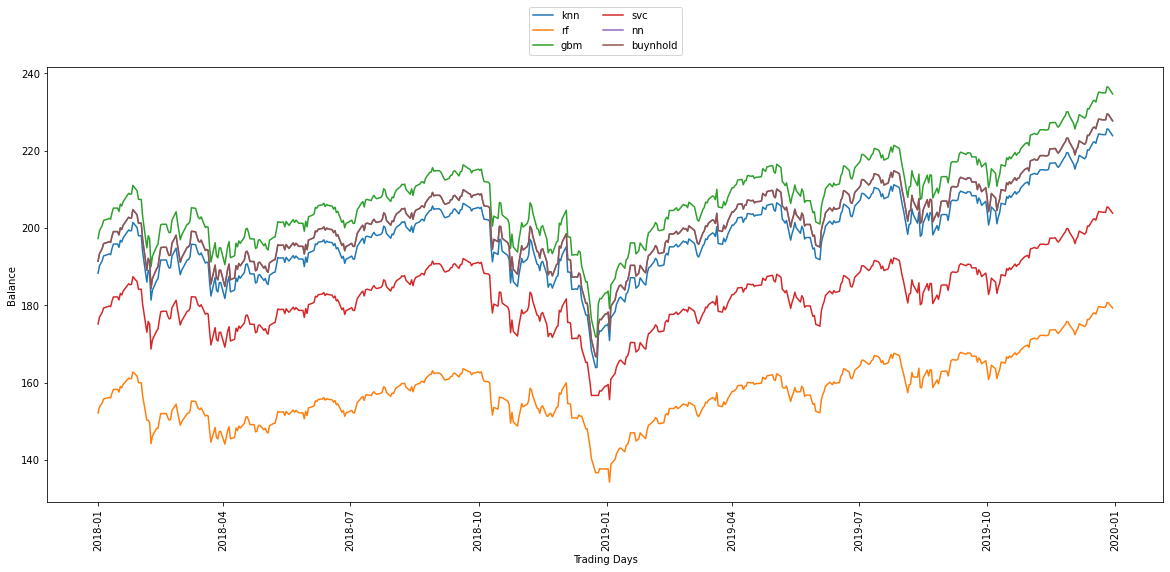

In [139]:
# define baseline model
def neural_model(neuron_hidden=5, activation_hidden='tanh', optimizer='adam', dropout=0.1, weight_decay=0.3):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2019 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2019.fit(x_train_periode_2019, y_train_periode_2019)
y_pred_train_nn=model_2019.predict(x_train_periode_2019)
y_pred_test_nn=model_2019.predict(x_test_periode_2019)


y_pred_test_knn, y_pred_train_knn = getKNN('euclidean', 'uniform', 20, 400, x_train_periode_2019, y_train_periode_2019, x_test_periode_2019)
y_pred_test_rf, y_pred_train_rf = getRF(300, 2, 'auto', x_train_periode_2019, y_train_periode_2019, x_test_periode_2019)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 4, 0.005, 931, x_train_periode_2019, y_train_periode_2019, x_test_periode_2019)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.1, x_train_periode_2019, y_train_periode_2019, x_test_periode_2019)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)

periode = 2019
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

## Fitting the Models and Trading for Periode 2021

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 10)                1910      
                                                                 
 dropout_36 (Dropout)        (None, 10)                0         
                                                                 
 dense_73 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,943
Trainable params: 1,943
Non-trainable params: 0
_________________________________________________________________


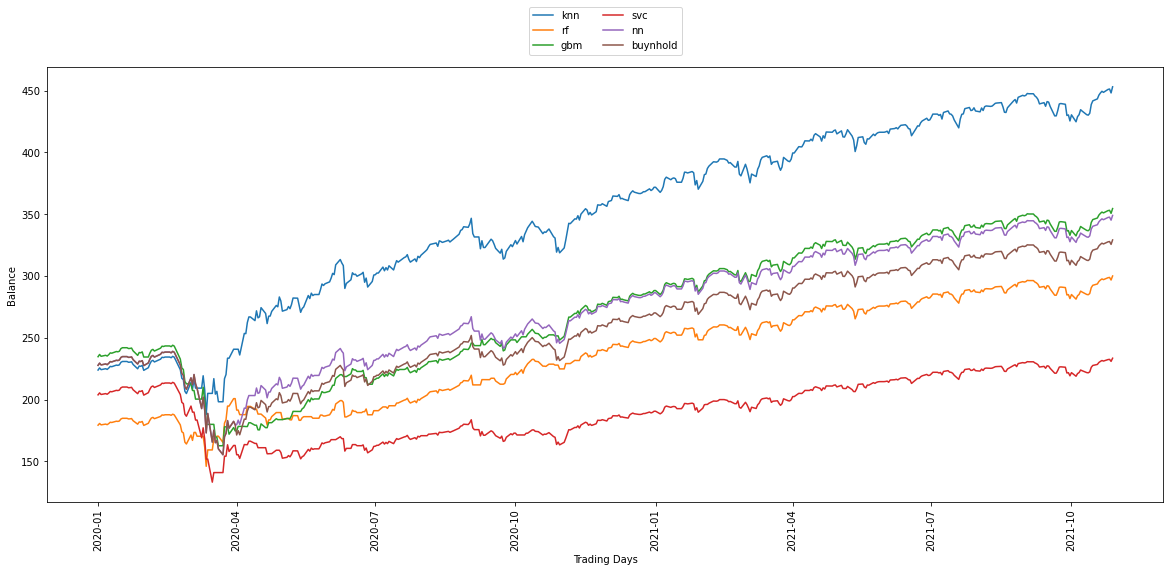

In [140]:
# define baseline model
def neural_model(neuron_hidden=10, activation_hidden='tanh', optimizer='adam', dropout=0.1, weight_decay=0.1):
    # create model
    model = Sequential()
    model.add(Dense(neuron_hidden, input_shape=(190,), activation=activation_hidden, use_bias=True, kernel_regularizer=regularizers.l1(weight_decay)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation='softmax', use_bias=True))
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model_2021 = KerasClassifier(build_fn=neural_model, 
                            epochs=100, 
                            batch_size=50, 
                            verbose=0)
model_2021.fit(x_train_periode_2021, y_train_periode_2021)
y_pred_train_nn=model_2021.predict(x_train_periode_2021)
y_pred_test_nn=model_2021.predict(x_test_periode_2021)


y_pred_test_knn, y_pred_train_knn = getKNN('manhattan', 'distance', 20, 250, x_train_periode_2021, y_train_periode_2021, x_test_periode_2021)
y_pred_test_rf, y_pred_train_rf = getRF(500, 2, 'log2', x_train_periode_2021, y_train_periode_2021, x_test_periode_2021)
y_pred_test_gbm, y_pred_train_gbm = getGBM(100, 3, 2, 0.05, 800, x_train_periode_2021, y_train_periode_2021, x_test_periode_2021)
y_pred_test_svc, y_pred_train_svc = getSVC('poly', 0.5, x_train_periode_2021, y_train_periode_2021, x_test_periode_2021)
y_pred_test_buynhold = [2] * len(y_pred_test_knn)

periode = 2021
for ml in ml_algos:
    globals()[f"trading_{ml}_{periode}"], globals()[f"trading_{ml}_{periode}_bool"] = getTradingResult(globals()[f"y_pred_test_{ml}"], periode, ml)
    globals()[f"total_trading_{ml}"] = globals()[f"total_trading_{ml}"] + globals()[f"trading_{ml}_{periode}"]
    plt.plot(globals()[f"df_test_periode_{periode}"][['DATE']].values[:-1] ,globals()[f"trading_{ml}_{periode}"], label=ml)

plt.xticks(rotation=90)
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

## Total timespan

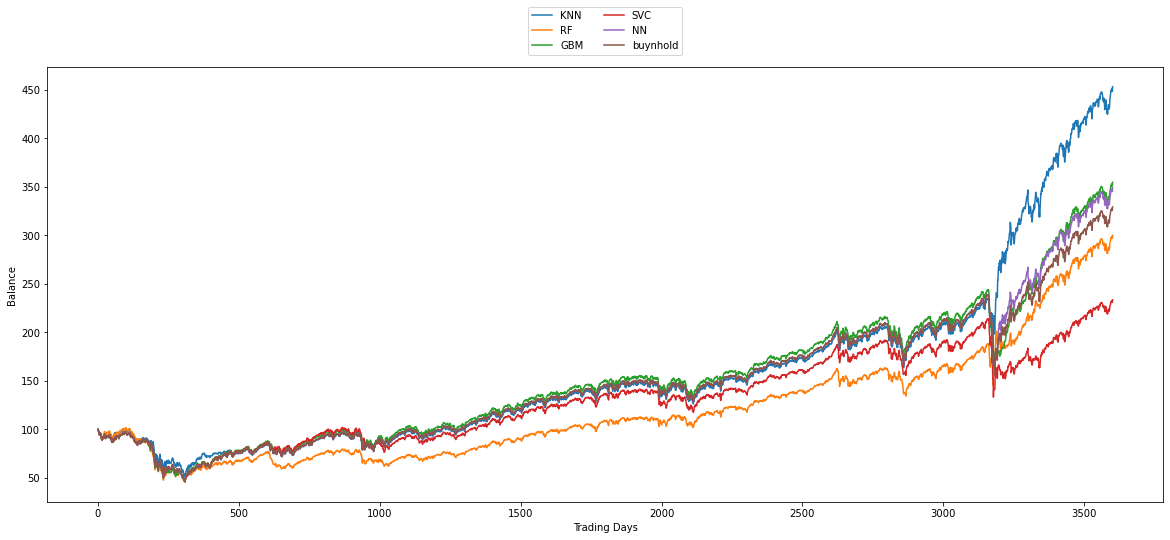

In [141]:
plt.plot(total_trading_knn, label='KNN')
plt.plot(total_trading_rf, label='RF')
plt.plot(total_trading_gbm, label='GBM')
plt.plot(total_trading_svc, label='SVC')
plt.plot(total_trading_nn, label='NN')
plt.plot(total_trading_buynhold, label='buynhold')
plt.xlabel("Trading Days")
plt.ylabel("Balance")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

The process of the models is very similar over time, with some of the models outperforming the others during different periods. The deviation in 2020 is due to the Covid Pandemic which caused the real world returns to fall steeply for a short period of time while the predicted returns would indicate to hold or buy. The process of the models is very similar over time, with some of the models outperforming the others during different periods. The deviation in 2020 is due to the Covid Pandemic which caused the real world returns to fall steeply for a short period of time.              

# Conclusion

In the trading strategy, the the KNN model outperformed the other machine learning models in predicting the returns of the Wilshire 5000. However, this outcome is not consistent, as due to the large number of hyperparameters and the large time spans, the predictions of the different models are not unambiguous and may vary with multiple simulations. 